In [2]:
import os
import numpy as np
import networkx as nx
import re
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
# Read all files
files_paths = []
for root, _, files in os.walk("./results"):  # os.walk for recursive 
   for file in files:
       files_paths.append(os.path.join(root, file))  # Construct full path

In [4]:
def read_adjacency_matrix(filename):
    """
    Reads an adjacency matrix .txt file and converts it to a NumPy array.
    
    Args:
        filename: The path to the file containing the adjacency matrix.
    
    Returns:
        A NumPy array representing the adjacency matrix.
    """
    with open(filename, 'r') as f:
        lines = f.readlines()
        
    matrix = []
    for line in lines:
        line = line.strip().split()
        matrix.append(line)
        
    return np.array(matrix, dtype = "int32")

In [5]:
def load_adjacency_matrices(conservative = True, c = 0):
    
    if conservative:
        cons = "conservative"
    else:
        cons = "nconservative"
        
    cx = "c"+str(int(c))
    
    adjacency_matrices = dict()
    for covar in ["raw","mpi_poor"]:
        output = dict()
        regexpr = covar+"_"+cons+"_"+cx
        files = [s for s in files_paths if re.search(regexpr, s)]
        for file in files:
            adj_matrix = read_adjacency_matrix(file)
            country = re.sub(r"^(\./results\\\\)", "", file).split("_")[0][-3:]
            output[country] = adj_matrix
        adjacency_matrices[covar] = output
    
    return adjacency_matrices

In [6]:
adjacency_matrices = load_adjacency_matrices(True, 0)

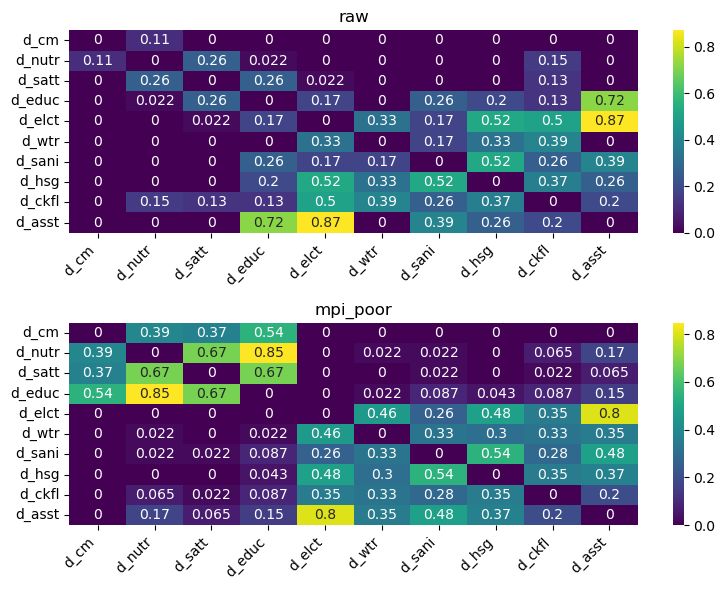

In [7]:
fig, axes = plt.subplots(2, 1, figsize=(8, 6))  # 2x2 grid, adjust figsize as needed
i = 0
for covar in adjacency_matrices:
    all_adj_matrices = list(adjacency_matrices[covar].values())
    edges_proportions = np.sum(all_adj_matrices, axis = 0) / len(all_adj_matrices)
    labels = ['d_cm', 'd_nutr', 'd_satt', 'd_educ', 'd_elct', 'd_wtr', 'd_sani','d_hsg', 'd_ckfl', 'd_asst'] 
    edges_proportions_df = pd.DataFrame(edges_proportions)
    edges_proportions_df.index = labels

    sns.heatmap(edges_proportions_df,ax=axes[i], annot=True, cmap="viridis")
    axes[i].set_xticks(np.arange(len(labels)) + 0.5)  # Center labels on ticks
    axes[i].set_xticklabels(labels, rotation=45, ha='right')  # Set and rotate x labels
    axes[i].set_title(covar) #Set the title for each plot
    i+=1


plt.tight_layout()  # Adjust spacing between subplots
plt.show()

In [41]:
def create_graph_from_adjacency_matrix(adj_matrix, directed=False):
    """
    Creates a NetworkX graph from an adjacency matrix.

    Args:
        adj_matrix: A NumPy 2D array representing the adjacency matrix.
        directed: If True, creates a directed graph. Otherwise, creates an undirected graph.

    Returns:
        A NetworkX graph object.  Returns None if the input is not a valid square matrix.
    """

    rows, cols = adj_matrix.shape
    if rows != cols:
        print("Adjacency matrix must be square.")
        return None

    if directed:
        graph = nx.DiGraph()  # Directed graph
    else:
        graph = nx.Graph()  # Undirected graph

    for i in range(rows):
        for j in range(cols):
            if adj_matrix[i, j] != 0:  # Add edge if the corresponding matrix element is non-zero
                if adj_matrix[i, j] == 1 or not isinstance(adj_matrix[i,j],(int, np.integer)): # unweighted
                    graph.add_edge(i, j)
                else: # weighted
                    graph.add_edge(i, j, weight=adj_matrix[i, j]) # Add edge with weight



    return graph

In [42]:
def degrees(x):
    graph = create_graph_from_adjacency_matrix(x)
    degrees = dict(graph.degree())  # Get existing degrees
    all_degrees = {}
    all_nodes = list(range(10))
    for node in all_nodes:
        all_degrees[node] = degrees.get(node, 0)  # Default to 0 if not in graph
    return all_degrees

### Degrees

In [43]:
raw_degrees = None
for x in adjacency_matrices['raw']:
    y = pd.DataFrame.from_dict(degrees(adjacency_matrices['raw'][x]), orient = 'index', columns = [x])
    if raw_degrees is None:
        raw_degrees = y  # First DataFrame, just assign it
    else:
        raw_degrees = raw_degrees.merge(y, left_index=True, right_index=True, how='outer')

In [44]:
raw_degrees

,tgo,sur,tha,zaf,com,srb,pry,bgd,dza,sle,...,ben,moz,mdg,fji,lbr,blz,kgz,arg,gmb,nam
0,1,0,1,0,1,0,1,1,0,1,...,2,1,2,0,0,1,0,0,1,1
1,2,0,1,1,2,0,1,3,1,1,...,3,3,3,0,1,1,1,0,2,3
2,2,1,0,0,2,1,1,2,2,2,...,3,3,4,0,1,1,0,0,3,2
3,4,3,4,2,1,2,3,4,4,5,...,5,3,5,1,4,1,0,1,3,3
4,9,2,2,4,4,1,3,4,5,7,...,5,6,6,2,3,4,0,1,7,5
5,3,2,1,2,1,1,3,3,2,2,...,3,4,5,1,2,1,2,1,2,3
6,3,5,2,2,3,1,5,5,6,2,...,6,5,3,2,2,2,1,2,3,3
7,5,2,3,2,3,1,6,6,3,5,...,5,7,6,1,5,3,1,2,3,5
8,4,2,3,4,5,4,4,5,3,1,...,5,3,2,5,1,5,2,2,4,8
9,3,7,3,3,4,1,3,7,2,4,...,3,3,4,4,3,3,1,5,2,3


In [45]:
# Average degree of each node (indicator)
raw_degrees.mean(axis = 1)

0    0.804348
1    1.673913
2    1.804348
3    2.891304
4    4.043478
5    2.304348
6    3.130435
7    3.913043
8    4.086957
9    3.521739
dtype: float64

In [46]:
raw_degrees

,tgo,sur,tha,zaf,com,srb,pry,bgd,dza,sle,...,ben,moz,mdg,fji,lbr,blz,kgz,arg,gmb,nam
0,1,0,1,0,1,0,1,1,0,1,...,2,1,2,0,0,1,0,0,1,1
1,2,0,1,1,2,0,1,3,1,1,...,3,3,3,0,1,1,1,0,2,3
2,2,1,0,0,2,1,1,2,2,2,...,3,3,4,0,1,1,0,0,3,2
3,4,3,4,2,1,2,3,4,4,5,...,5,3,5,1,4,1,0,1,3,3
4,9,2,2,4,4,1,3,4,5,7,...,5,6,6,2,3,4,0,1,7,5
5,3,2,1,2,1,1,3,3,2,2,...,3,4,5,1,2,1,2,1,2,3
6,3,5,2,2,3,1,5,5,6,2,...,6,5,3,2,2,2,1,2,3,3
7,5,2,3,2,3,1,6,6,3,5,...,5,7,6,1,5,3,1,2,3,5
8,4,2,3,4,5,4,4,5,3,1,...,5,3,2,5,1,5,2,2,4,8
9,3,7,3,3,4,1,3,7,2,4,...,3,3,4,4,3,3,1,5,2,3


In [47]:
sum_degrees = raw_degrees.sum(axis=0)
degrees_by_indicator = raw_degrees.div(sum_degrees, axis=1)
degrees_by_indicator

,tgo,sur,tha,zaf,com,srb,pry,bgd,dza,sle,...,ben,moz,mdg,fji,lbr,blz,kgz,arg,gmb,nam
0,0.027778,0.000000,0.05,0.00,0.038462,0.000000,0.033333,0.025,0.000000,0.033333,...,0.050,0.026316,0.050,0.0000,0.000000,0.045455,0.000,0.000000,0.033333,0.027778
1,0.055556,0.000000,0.05,0.05,0.076923,0.000000,0.033333,0.075,0.035714,0.033333,...,0.075,0.078947,0.075,0.0000,0.045455,0.045455,0.125,0.000000,0.066667,0.083333
2,0.055556,0.041667,0.00,0.00,0.076923,0.083333,0.033333,0.050,0.071429,0.066667,...,0.075,0.078947,0.100,0.0000,0.045455,0.045455,0.000,0.000000,0.100000,0.055556
3,0.111111,0.125000,0.20,0.10,0.038462,0.166667,0.100000,0.100,0.142857,0.166667,...,0.125,0.078947,0.125,0.0625,0.181818,0.045455,0.000,0.071429,0.100000,0.083333
4,0.250000,0.083333,0.10,0.20,0.153846,0.083333,0.100000,0.100,0.178571,0.233333,...,0.125,0.157895,0.150,0.1250,0.136364,0.181818,0.000,0.071429,0.233333,0.138889
5,0.083333,0.083333,0.05,0.10,0.038462,0.083333,0.100000,0.075,0.071429,0.066667,...,0.075,0.105263,0.125,0.0625,0.090909,0.045455,0.250,0.071429,0.066667,0.083333
6,0.083333,0.208333,0.10,0.10,0.115385,0.083333,0.166667,0.125,0.214286,0.066667,...,0.150,0.131579,0.075,0.1250,0.090909,0.090909,0.125,0.142857,0.100000,0.083333
7,0.138889,0.083333,0.15,0.10,0.115385,0.083333,0.200000,0.150,0.107143,0.166667,...,0.125,0.184211,0.150,0.0625,0.227273,0.136364,0.125,0.142857,0.100000,0.138889
8,0.111111,0.083333,0.15,0.20,0.192308,0.333333,0.133333,0.125,0.107143,0.033333,...,0.125,0.078947,0.050,0.3125,0.045455,0.227273,0.250,0.142857,0.133333,0.222222
9,0.083333,0.291667,0.15,0.15,0.153846,0.083333,0.100000,0.175,0.071429,0.133333,...,0.075,0.078947,0.100,0.2500,0.136364,0.136364,0.125,0.357143,0.066667,0.083333


In [48]:
degrees_by_indicator.columns

Index(['tgo', 'sur', 'tha', 'zaf', 'com', 'srb', 'pry', 'bgd', 'dza', 'sle',
       'tun', 'cub', 'gnb', 'mwi', 'gin', 'hnd', 'zmb', 'guy', 'mng', 'tcd',
       'bfa', 'mda', 'eth', 'zwe', 'ner', 'ton', 'civ', 'sdn', 'gab', 'kaz',
       'tza', 'cmr', 'mrt', 'geo', 'kir', 'irq', 'ben', 'moz', 'mdg', 'fji',
       'lbr', 'blz', 'kgz', 'arg', 'gmb', 'nam'],
      dtype='object')

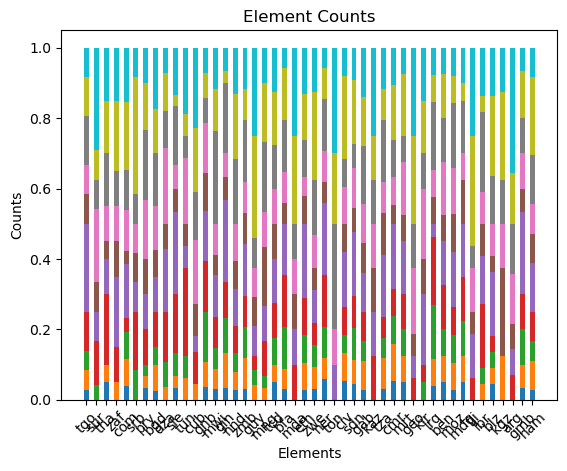

In [49]:
import matplotlib.pyplot as plt

countries = (
    degrees_by_indicator.columns
)
degree_counts = {}
for i in degrees_by_indicator.index:
    degree_counts[str(i)] = np.array(degrees_by_indicator.iloc[i])

width = 0.5

fig, ax = plt.subplots()
bottom = np.zeros(len(countries))

# Bar plot
for boolean, weight_count in degree_counts.items():
    p = ax.bar(countries, weight_count, width, label=boolean, bottom=bottom)
    bottom += weight_count
plt.xticks(rotation=45)
plt.xlabel("Elements")
plt.ylabel("Counts")
plt.title("Element Counts")
plt.show()

In [50]:
mpi_poor_degrees = None
for x in adjacency_matrices['mpi_poor']:
    y = pd.DataFrame.from_dict(degrees(adjacency_matrices['mpi_poor'][x]), orient = 'index', columns = [x])
    if mpi_poor_degrees is None:
        mpi_poor_degrees = y  # First DataFrame, just assign it
    else:
        mpi_poor_degrees = mpi_poor_degrees.merge(y, left_index=True, right_index=True, how='outer')

In [51]:
mpi_poor_degrees

,tgo,sur,tha,zaf,com,srb,pry,bgd,dza,sle,...,ben,moz,mdg,fji,lbr,blz,kgz,arg,gmb,nam
0,4,1,2,1,2,0,0,4,2,4,...,4,2,1,0,4,0,0,2,1,1
1,4,1,3,2,3,0,2,8,2,5,...,5,4,4,1,4,1,1,2,4,6
2,4,1,3,0,2,1,2,6,3,4,...,5,3,3,0,4,0,0,0,3,2
3,4,6,5,2,3,2,5,8,5,5,...,7,4,4,1,4,1,0,2,6,4
4,5,2,1,5,3,1,3,6,4,4,...,5,5,5,2,3,4,0,1,5,6
5,5,1,1,3,1,1,3,5,1,3,...,7,4,7,1,6,1,2,1,1,5
6,2,5,2,2,2,1,4,8,5,4,...,5,4,4,2,2,2,1,2,3,3
7,4,2,2,2,3,1,5,6,2,4,...,5,5,3,1,4,2,1,2,1,3
8,4,2,5,3,2,4,4,5,2,2,...,3,3,2,5,1,3,2,2,3,3
9,6,5,4,2,3,1,2,8,2,7,...,6,6,7,3,4,2,1,4,3,3


In [52]:
# Average degree of each node (indicator)
mpi_poor_degrees.mean(axis = 1)

0    2.108696
1    3.369565
2    2.760870
3    3.956522
4    3.739130
5    3.391304
6    3.326087
7    3.173913
8    3.217391
9    4.478261
dtype: float64

In [53]:
# This is the average degree values of each node (indicators) for the raw indicators and those conditional to multidimensional poverty
pd.concat([raw_degrees.mean(axis = 1),mpi_poor_degrees.mean(axis = 1)], axis = 1)

,0,1
0,0.804348,2.108696
1,1.673913,3.369565
2,1.804348,2.760870
3,2.891304,3.956522
4,4.043478,3.739130
5,2.304348,3.391304
6,3.130435,3.326087
7,3.913043,3.173913
8,4.086957,3.217391
9,3.521739,4.478261


In [54]:
measures = pd.read_excel("./data/Table 1 National Results MPI 2024.xlsx", skiprows=8, index_col=0).iloc[:,[0,1,2,3,4,5,6,7]].dropna()
measures.columns = ["iso","country","region","survey","year","MPI","H","A"]
measures.set_index("iso")

raw = pd.read_excel("./data/Table 1 National Results MPI 2024.xlsx", skiprows=8, index_col=0, sheet_name="1.6 Uncensored Headcounts").iloc[:,[0,1,2,3,4] + list(range(6, 16))].dropna()
raw.columns = ["iso","country","region","survey","year","d_nutr","d_cm","d_educ","d_satt","d_ckfl","d_sani","d_wtr","d_elct","d_hsg","d_asst"]
raw.set_index("iso")
raw

censored = pd.read_excel("./data/Table 1 National Results MPI 2024.xlsx", skiprows=8, index_col=0, sheet_name="1.2 Censored Headcounts").iloc[:,[0,1,2,3,4] + list(range(6, 16))].dropna()
censored.columns = ["iso","country","region","survey","year","d_nutr","d_cm","d_educ","d_satt","d_ckfl","d_sani","d_wtr","d_elct","d_hsg","d_asst"]
censored.set_index("iso")
censored.loc[(censored["country"] == "Rwanda"),:]

,iso,country,region,survey,year,d_nutr,d_cm,d_educ,d_satt,d_ckfl,d_sani,d_wtr,d_elct,d_hsg,d_asst
646,RWA,Rwanda,Sub-Saharan Africa,DHS,2019-2020,23.048536,3.254854,28.911352,7.950016,48.727028,24.896296,34.808714,36.540896,44.436675,36.899645


In [55]:
"rwa" in adjacency_matrices['mpi_poor']

False

## Connected (and disconnected components)

In [29]:
all_cliques = []
for x in adjacency_matrices['mpi_poor']:
    G = create_graph_from_adjacency_matrix(adjacency_matrices['mpi_poor'][x])
    all_cliques.append(list(nx.connected_components(G)))

In [30]:
all_cliques

[[{0, 1, 2, 3, 4, 5, 6, 7, 9}],
 [{1, 3, 4, 6, 9}],
 [{0, 1, 2, 3, 4, 6, 7, 8, 9}],
 [{0, 1, 3}, {4, 5, 6, 8, 9}],
 [{0, 1, 2, 3}, {4, 5, 6, 7, 8, 9}],
 [{3, 6, 8}, {4, 9}],
 [{1, 2, 3, 6, 7, 8}, {4, 5, 9}],
 [{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}],
 [{0, 1, 2, 3, 4, 5, 6, 9}],
 [{0, 1, 2, 3}, {4, 5, 6, 7, 9}],
 [{1, 2, 3, 9}, {5, 6}],
 [{1, 3}, {5, 6, 7, 8, 9}],
 [{0, 1, 2, 3, 4, 5, 6, 7, 9}],
 [{0, 1, 2, 3, 4, 5, 6, 7, 9}],
 [{0, 1, 2, 3}, {4, 6, 7, 9}],
 [{0, 1, 2, 3}, {4, 6, 7, 8, 9}],
 [{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}],
 [{1, 3}, {4, 5, 7, 8, 9}],
 [{0, 1, 2, 3}, {4, 9}, {5, 6, 7, 8}],
 [{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}],
 [{0, 1, 2, 3}, {4, 5, 7, 8}],
 [{3, 4, 5, 6, 7, 8, 9}],
 [{1, 2, 3}, {4, 5, 6, 7, 8, 9}],
 [{0, 1, 2, 3}, {4, 5, 6, 7, 8, 9}],
 [{1, 2, 3, 8}, {4, 5, 6, 7, 9}],
 [{4, 7, 8, 9}],
 [{0, 1, 2, 3}, {4, 5, 6, 7, 8, 9}],
 [{0, 1, 2, 3, 4, 5, 6, 8, 9}],
 [{0, 1, 2, 3}, {4, 5, 6, 7, 8, 9}],
 [{0, 1}, {4, 9}, {5, 8}, {6, 7}],
 [{0, 1, 2, 3}, {4, 5, 6, 7, 9}],
 [{1, 2, 3, 4, 5, 6, 

###### 

In [31]:
from collections import Counter

In [32]:
flattened_list = []
for sublist in all_cliques:
    new_sublist = []
    for item in sublist:
        if isinstance(item, list):  # Check if the item is a list
            new_sublist.append(tuple(item)) # Convert to tuple
        else:
            new_sublist.append(item)
    flattened_list.extend(new_sublist)

In [57]:
flattened_list

[{0, 1, 2, 3, 4, 5, 6, 7, 9},
 {1, 3, 4, 6, 9},
 {0, 1, 2, 3, 4, 6, 7, 8, 9},
 {0, 1, 3},
 {4, 5, 6, 8, 9},
 {0, 1, 2, 3},
 {4, 5, 6, 7, 8, 9},
 {3, 6, 8},
 {4, 9},
 {1, 2, 3, 6, 7, 8},
 {4, 5, 9},
 {0, 1, 2, 3, 4, 5, 6, 7, 8, 9},
 {0, 1, 2, 3, 4, 5, 6, 9},
 {0, 1, 2, 3},
 {4, 5, 6, 7, 9},
 {1, 2, 3, 9},
 {5, 6},
 {1, 3},
 {5, 6, 7, 8, 9},
 {0, 1, 2, 3, 4, 5, 6, 7, 9},
 {0, 1, 2, 3, 4, 5, 6, 7, 9},
 {0, 1, 2, 3},
 {4, 6, 7, 9},
 {0, 1, 2, 3},
 {4, 6, 7, 8, 9},
 {0, 1, 2, 3, 4, 5, 6, 7, 8, 9},
 {1, 3},
 {4, 5, 7, 8, 9},
 {0, 1, 2, 3},
 {4, 9},
 {5, 6, 7, 8},
 {0, 1, 2, 3, 4, 5, 6, 7, 8, 9},
 {0, 1, 2, 3},
 {4, 5, 7, 8},
 {3, 4, 5, 6, 7, 8, 9},
 {1, 2, 3},
 {4, 5, 6, 7, 8, 9},
 {0, 1, 2, 3},
 {4, 5, 6, 7, 8, 9},
 {1, 2, 3, 8},
 {4, 5, 6, 7, 9},
 {4, 7, 8, 9},
 {0, 1, 2, 3},
 {4, 5, 6, 7, 8, 9},
 {0, 1, 2, 3, 4, 5, 6, 8, 9},
 {0, 1, 2, 3},
 {4, 5, 6, 7, 8, 9},
 {0, 1},
 {4, 9},
 {5, 8},
 {6, 7},
 {0, 1, 2, 3},
 {4, 5, 6, 7, 9},
 {1, 2, 3, 4, 5, 6, 7, 8, 9},
 {1, 2, 3, 4, 5, 6, 7, 8, 9},
 

In [59]:
sorted_list = sorted(flattened_list, key=str) # Sort by string representation to handle tuples
tuple_list = [tuple(sorted(item)) if isinstance(item, set) else item for item in flattened_list]
max_cliques_counts = Counter(tuple_list)

In [64]:
max_cliques_counts

Counter({(0, 1, 2, 3, 4, 5, 6, 7, 9): 3,
         (1, 3, 4, 6, 9): 1,
         (0, 1, 2, 3, 4, 6, 7, 8, 9): 1,
         (0, 1, 3): 2,
         (4, 5, 6, 8, 9): 1,
         (0, 1, 2, 3): 12,
         (4, 5, 6, 7, 8, 9): 7,
         (3, 6, 8): 1,
         (4, 9): 4,
         (1, 2, 3, 6, 7, 8): 1,
         (4, 5, 9): 1,
         (0, 1, 2, 3, 4, 5, 6, 7, 8, 9): 4,
         (0, 1, 2, 3, 4, 5, 6, 9): 1,
         (4, 5, 6, 7, 9): 5,
         (1, 2, 3, 9): 1,
         (5, 6): 1,
         (1, 3): 4,
         (5, 6, 7, 8, 9): 1,
         (4, 6, 7, 9): 1,
         (4, 6, 7, 8, 9): 2,
         (4, 5, 7, 8, 9): 1,
         (5, 6, 7, 8): 1,
         (4, 5, 7, 8): 1,
         (3, 4, 5, 6, 7, 8, 9): 1,
         (1, 2, 3): 2,
         (1, 2, 3, 8): 1,
         (4, 7, 8, 9): 1,
         (0, 1, 2, 3, 4, 5, 6, 8, 9): 1,
         (0, 1): 1,
         (5, 8): 1,
         (6, 7): 1,
         (1, 2, 3, 4, 5, 6, 7, 8, 9): 3,
         (4, 6, 8, 9): 2,
         (0, 1, 2): 1,
         (0, 1, 2, 3, 5, 7, 8): 1,
  

In [65]:
counts = {}
for key, value in dict(max_cliques_counts).items():
    counts[str(key)] = value

In [66]:
counts

{'(0, 1, 2, 3, 4, 5, 6, 7, 9)': 3,
 '(1, 3, 4, 6, 9)': 1,
 '(0, 1, 2, 3, 4, 6, 7, 8, 9)': 1,
 '(0, 1, 3)': 2,
 '(4, 5, 6, 8, 9)': 1,
 '(0, 1, 2, 3)': 12,
 '(4, 5, 6, 7, 8, 9)': 7,
 '(3, 6, 8)': 1,
 '(4, 9)': 4,
 '(1, 2, 3, 6, 7, 8)': 1,
 '(4, 5, 9)': 1,
 '(0, 1, 2, 3, 4, 5, 6, 7, 8, 9)': 4,
 '(0, 1, 2, 3, 4, 5, 6, 9)': 1,
 '(4, 5, 6, 7, 9)': 5,
 '(1, 2, 3, 9)': 1,
 '(5, 6)': 1,
 '(1, 3)': 4,
 '(5, 6, 7, 8, 9)': 1,
 '(4, 6, 7, 9)': 1,
 '(4, 6, 7, 8, 9)': 2,
 '(4, 5, 7, 8, 9)': 1,
 '(5, 6, 7, 8)': 1,
 '(4, 5, 7, 8)': 1,
 '(3, 4, 5, 6, 7, 8, 9)': 1,
 '(1, 2, 3)': 2,
 '(1, 2, 3, 8)': 1,
 '(4, 7, 8, 9)': 1,
 '(0, 1, 2, 3, 4, 5, 6, 8, 9)': 1,
 '(0, 1)': 1,
 '(5, 8)': 1,
 '(6, 7)': 1,
 '(1, 2, 3, 4, 5, 6, 7, 8, 9)': 3,
 '(4, 6, 8, 9)': 2,
 '(0, 1, 2)': 1,
 '(0, 1, 2, 3, 5, 7, 8)': 1,
 '(1, 5, 7, 8)': 1,
 '(6, 9)': 1,
 '(6, 7, 9)': 1,
 '(0, 1, 2, 3, 8)': 1,
 '(4, 5, 7)': 1}

In [67]:
pd.DataFrame.from_dict(counts)

ValueError: If using all scalar values, you must pass an index

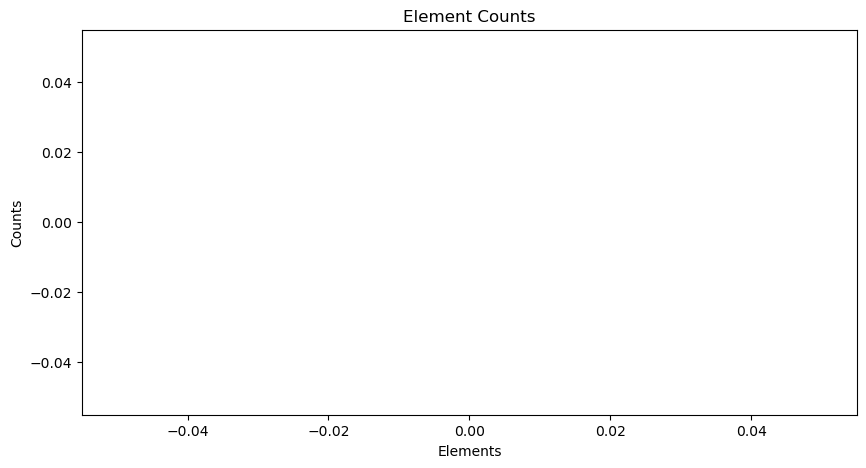

In [37]:
import matplotlib.pyplot as plt
# Extract elements and counts for plotting
elements = list(counts.keys())
counts_values = list(counts.values())

plt.figure(figsize=(10, 5))  # Adjust figure size if needed

# Bar plot
plt.plot(elements, counts_values)
plt.xlabel("Elements")
plt.ylabel("Counts")
plt.title("Element Counts")
plt.show()

In [38]:
pip install plotnine

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 21.0 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 64.1 MB/s eta 0:00:0000:010:01m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 62.8 MB/s eta 0:00:0000:010:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.4/127.4 kB 46.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 74.3 MB/s eta 0:00:0000:01:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.5/19.5 MB 53.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 321.9/321.9 kB 53.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 346.8/346.8 kB 20.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 3.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.9/232.9 kB 59.0 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.5
    Uninstalling numpy-1.21.5:
      Successfully uninstalle